In [1]:
#Imports

import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
#import time
#start_time = time.time()


Creating the DataFrame:

In [2]:
# Read the THE SPOTIFY JSON FILE into a DataFrame  
file_path = "StreamingHistorySezerKocaekiz.json"
df = pd.read_json(file_path)

#display(df)
#df.info()

Reshaping the DataFrame:

In [3]:
# Rename the columns
df.rename(columns={
    'endTime': 'End Time',
    'artistName': 'Artist Name',
    'trackName': 'Track Name',
    'msPlayed': 'Milliseconds Played'
}, inplace=True)

# Divide "Milliseconds Played" by 1000 to get "Seconds Played"
df['Seconds Played'] = df['Milliseconds Played'] / 1000

# Create "Time Of the Day Played" column
df['Time Of the Day Played'] = df['End Time'].str[-5:]

# Create "Date Played" column with the first 10 characters of "End Time"
df['Date Played'] = df['End Time'].str[:10]

# Convert "Date Played" to datetime format
df['Date Played'] = pd.to_datetime(df['Date Played'])

# Extract month and day of the week
df['Month'] = df['Date Played'].dt.month
df['Day of the Week'] = df['Date Played'].dt.strftime('%A')

# Define a dictionary to map month numbers to month names
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Map the month numbers to month names
df['Month'] = df['Month'].map(month_mapping)

# Create a new column with the combination of month name and year
df['Month With Year'] = df['Month'] + df['Date Played'].dt.year.astype(str)

# Divide "Milliseconds Played" by 60000 to get "Minutes Played"
df['Minutes Played'] = df['Milliseconds Played'] / 60000



# Filter rows where "Milliseconds Played" is greater than or equal to 10000
df = df[df['Milliseconds Played'] >= 10000]



# Type Convertions
df['End Time'] = pd.to_datetime(df['End Time'])
df['Time Of the Day Played'] = df['Time Of the Day Played'].astype(str)

# Adding Time Labels To DataFrame
time_bins = [0, 6, 12, 18, 24]
time_labels = ['Early Morning', 'Morning', 'Afternoon','Evening']

df['Time Of the Day Played'] = df['Time Of the Day Played'].str[:2] + '.' + df['Time Of the Day Played'].str[3:]

# Convert the "Time Of the Day Played" to integer
df['Time Of the Day Played'] = pd.to_numeric(df['Time Of the Day Played'].str.replace(':', ''), errors='coerce')
# Create a new column based on the conditions
df['Time of Day Category'] = pd.cut(df['Time Of the Day Played'], bins=time_bins, labels=time_labels, include_lowest=True)



display(df)

,End Time,Artist Name,Track Name,Milliseconds Played,Seconds Played,Time Of the Day Played,Date Played,Month,Day of the Week,Month With Year,Minutes Played,Time of Day Category
0,2022-11-25 14:33:00,Kid Cudi,"Solo Dolo, Pt. III",110008,110.008,14.33,2022-11-25,November,Friday,November2022,1.833467,Afternoon
1,2022-11-29 08:14:00,Ørpheus,Wild Child,135233,135.233,8.14,2022-11-29,November,Tuesday,November2022,2.253883,Morning
2,2022-11-29 13:03:00,ALIZADE,ANORMAL,103886,103.886,13.03,2022-11-29,November,Tuesday,November2022,1.731433,Afternoon
6,2022-11-29 13:05:00,Lvbel C5,olsun,124173,124.173,13.05,2022-11-29,November,Tuesday,November2022,2.069550,Afternoon
7,2022-11-29 16:44:00,Lvbel C5,10 NUMARA,16341,16.341,16.44,2022-11-29,November,Tuesday,November2022,0.272350,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...
2240,2023-11-26 18:53:00,Semicenk,Sevecek Sandım,111711,111.711,18.53,2023-11-26,November,Sunday,November2023,1.861850,Evening
2241,2023-11-26 18:55:00,ALIZADE,24/7,128731,128.731,18.55,2023-11-26,November,Sunday,November2023,2.145517,Evening
2245,2023-11-26 18:58:00,UZI,Umrumda Değil,185458,185.458,18.58,2023-11-26,November,Sunday,November2023,3.090967,Evening
2246,2023-11-26 19:00:00,cakal,YAKALARSAN,116499,116.499,19.00,2023-11-26,November,Sunday,November2023,1.941650,Evening


Exploring the Dataset

In [4]:
# First 3 rows
df.head(3)

,End Time,Artist Name,Track Name,Milliseconds Played,Seconds Played,Time Of the Day Played,Date Played,Month,Day of the Week,Month With Year,Minutes Played,Time of Day Category
0,2022-11-25 14:33:00,Kid Cudi,"Solo Dolo, Pt. III",110008,110.008,14.33,2022-11-25,November,Friday,November2022,1.833467,Afternoon
1,2022-11-29 08:14:00,Ørpheus,Wild Child,135233,135.233,8.14,2022-11-29,November,Tuesday,November2022,2.253883,Morning
2,2022-11-29 13:03:00,ALIZADE,ANORMAL,103886,103.886,13.03,2022-11-29,November,Tuesday,November2022,1.731433,Afternoon


In [5]:
# Info of dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1683 entries, 0 to 2247
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   End Time                1683 non-null   datetime64[ns]
 1   Artist Name             1683 non-null   object        
 2   Track Name              1683 non-null   object        
 3   Milliseconds Played     1683 non-null   int64         
 4   Seconds Played          1683 non-null   float64       
 5   Time Of the Day Played  1683 non-null   float64       
 6   Date Played             1683 non-null   datetime64[ns]
 7   Month                   1683 non-null   object        
 8   Day of the Week         1683 non-null   object        
 9   Month With Year         1683 non-null   object        
 10  Minutes Played          1683 non-null   float64       
 11  Time of Day Category    1683 non-null   category      
dtypes: category(1), datetime64[ns](2), float64(3), int64(

In [6]:
# Statistical summary of numerical columns
display(df.describe())

,End Time,Milliseconds Played,Seconds Played,Time Of the Day Played,Date Played,Minutes Played
count,1683,1683.000000,1683.000000,1683.000000,1683,1683.000000
mean,2023-07-24 05:14:17.183600640,135529.000594,135.529001,14.671563,2023-07-23 14:22:27.593583104,2.258817
min,2022-11-25 14:33:00,10164.000000,10.164000,2.500000,2022-11-25 00:00:00,0.169400
25%,2023-04-24 14:56:30,88125.500000,88.125500,11.300000,2023-04-24 00:00:00,1.468758
50%,2023-08-10 18:26:00,136874.000000,136.874000,15.450000,2023-08-10 00:00:00,2.281233
75%,2023-11-12 12:46:00,180000.000000,180.000000,18.295000,2023-11-12 00:00:00,3.000000
max,2023-11-26 19:01:00,575378.000000,575.378000,23.220000,2023-11-26 00:00:00,9.589633
std,NaN,73500.250253,73.500250,4.712097,NaN,1.225004


In [7]:
# Top 10 Artists in the dataframe
top_artists = df['Artist Name'].value_counts()
top_artists_top10 = top_artists.head(10)
print(top_artists_top10)

Artist Name
ALIZADE           240
cakal             155
Semicenk           57
UZI                56
Alok               44
Reckol             43
Destroy Lonely     35
Lana Del Rey       33
Güneş              32
Lvbel C5           32
Name: count, dtype: int64


In [8]:
# Top 10 Tracks in the dataframe
top_tracks = df['Track Name'].value_counts()
top_tracks_top10 = top_tracks.head(10)
print(top_tracks_top10)

Track Name
ANORMAL                                                   42
Kalbin bana kaldı                                         35
Aşk Olsun                                                 32
24/7                                                      31
Headlights (feat. KIDDO & Issam Alnajjar) - Radio Edit    28
YAKALARSAN                                                27
Diyardan Diyara                                           26
Feragât                                                   22
not me mix                                                21
ŞU AN                                                     21
Name: count, dtype: int64


In [9]:
# From decending order music played number for days of the week
day_counts = df['Day of the Week'].value_counts()
print(day_counts)

Day of the Week
Monday       299
Thursday     298
Wednesday    267
Friday       230
Saturday     221
Sunday       197
Tuesday      171
Name: count, dtype: int64


In [10]:
# On Mondays most music has been played
# If needed The_day variable can be rewritten to further investigate the data
The_day = "Monday"

# Filter the DataFrame for entries where the Day of the Week is Monday
monday_df = df[df['Day of the Week'] == The_day]

# Find the most frequently played track on Mondays
most_played_track_monday = monday_df['Track Name'].value_counts().idxmax()
max_count_monday = monday_df['Track Name'].value_counts().max()

print(f"The most frequently played track on {The_day} is '{most_played_track_monday}' with {max_count_monday} plays.")



The most frequently played track on Monday is 'Escapism. - Sped Up' with 10 plays.


In [11]:
# Longest Minutes Played month
# Group the DataFrame by Month With Year and sum the Minutes Played within each group
monthly_totals = df.groupby('Month With Year')['Minutes Played'].sum()

# Find the month with the maximum total Minutes Played
longest_month = monthly_totals.idxmax()
max_minutes_longest_month = monthly_totals.max()
hour_equalivent = max_minutes_longest_month/60
print(f"The month with the longest total Minutes Played is '{longest_month}' with a total of {round(max_minutes_longest_month,2)} minutes. Which equals to {round(hour_equalivent,2)} hours.")


The month with the longest total Minutes Played is 'November2023' with a total of 1248.74 minutes. Which equals to 20.81 hours.


Visualization and Analysis

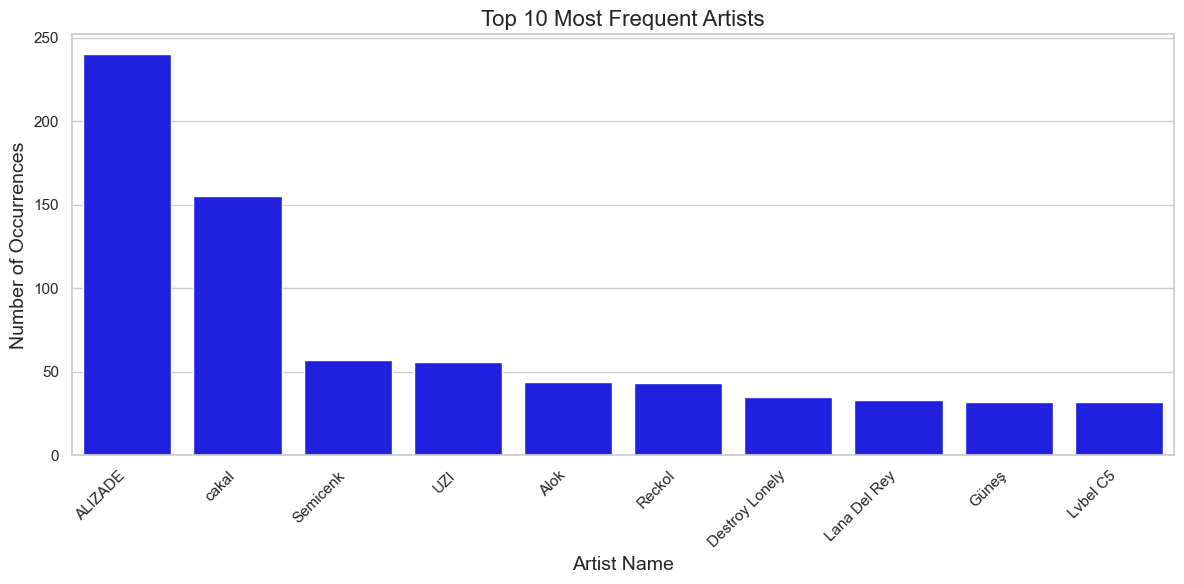

In [12]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.countplot(x='Artist Name', data=df, order=df['Artist Name'].value_counts().index[:10], color='blue')

# Customize the plot
plt.title('Top 10 Most Frequent Artists', fontsize=16)
plt.xlabel('Artist Name', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

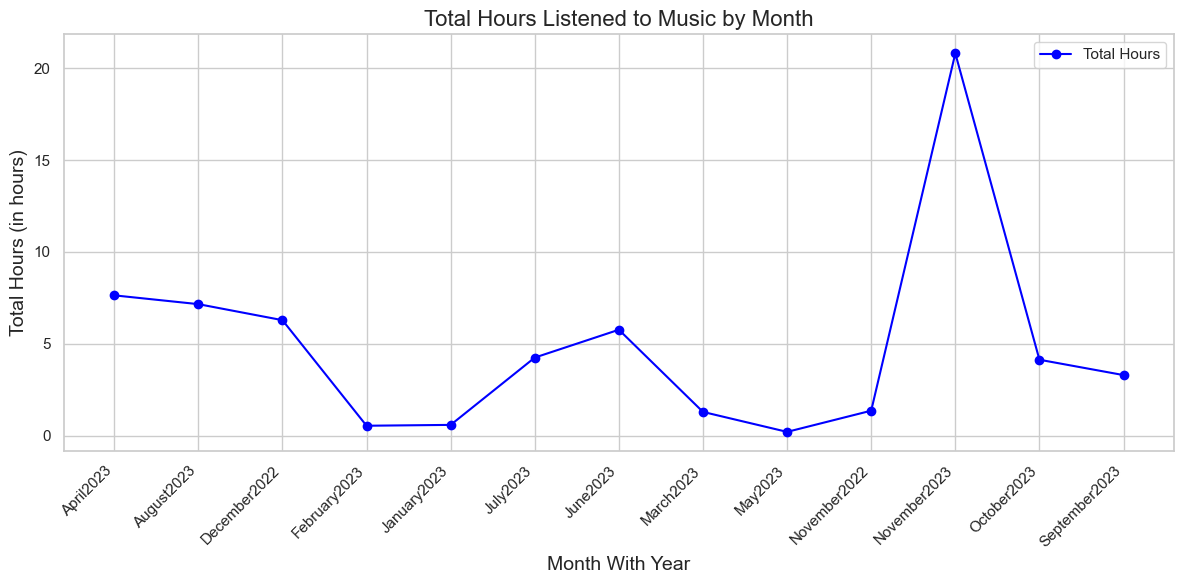

In [13]:
# Set the style for the plot 
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_totals.index, monthly_totals / 60, marker='o', color='blue', label='Total Hours')

# Customize the plot
plt.title('Total Hours Listened to Music by Month', fontsize=16)
plt.xlabel('Month With Year', fontsize=14)
plt.ylabel('Total Hours (in hours)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

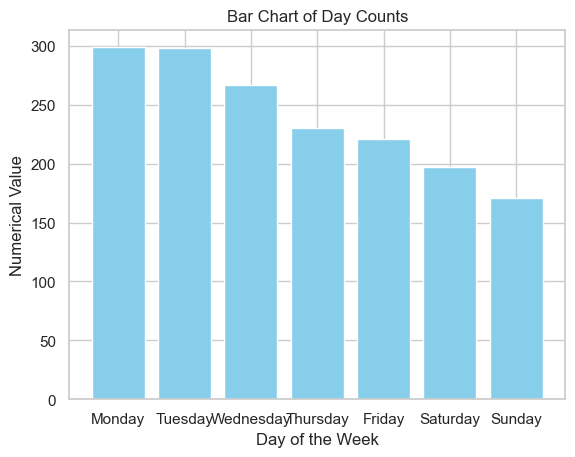

In [14]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting the bar chart
plt.bar(days_of_week, day_counts, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Numerical Value')
plt.title('Bar Chart of Day Counts')
plt.show()

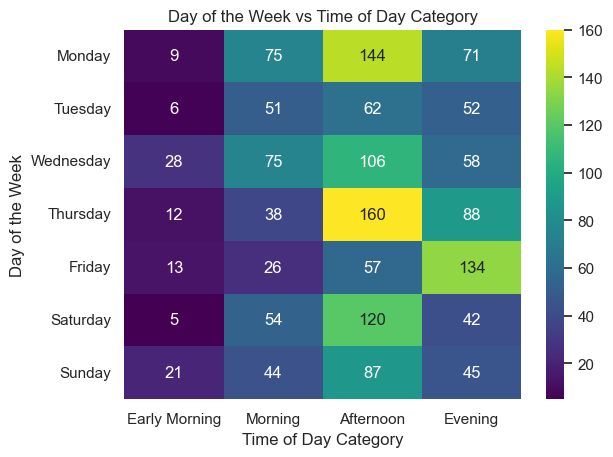

In [15]:
# Ensuring 'Day of the Week' and 'Time of Day Category' are categorical variables
df['Day of the Week'] = pd.Categorical(df['Day of the Week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['Time of Day Category'] = pd.Categorical(df['Time of Day Category'], categories=['Early Morning', 'Morning', 'Afternoon', 'Evening'], ordered=True)

# Create a pivot table for the heatmap
heatmap_data = df.pivot_table(index='Day of the Week', columns='Time of Day Category', aggfunc='size', fill_value=0)

# Plot the heatmap
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d', cbar=True)
plt.title('Day of the Week vs Time of Day Category')
plt.show()

Implementing the Machine Learning 

Pre Proccessing

In [16]:
# Copying the original dataframe
df_copy = df.copy()
#display(df_copy)

if df_copy.isnull().values.any():
    print("There are missing values in the dataframe.")
else:
    print("There are not any missing values in the dataframe.")
    


df_copy['Artist Name'] = pd.Categorical(df_copy['Artist Name']).codes

df_copy['Track Name'] = pd.Categorical(df_copy['Track Name']).codes

df_copy['Month'] = df_copy['Date Played'].dt.month

df_copy['Year'] = df_copy['Date Played'].dt.year

df_copy['Day'] = df_copy['Date Played'].dt.day

days_map = {'Monday':0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_copy['Day of the Week'] = df_copy['Day of the Week'].map(days_map).cat.codes

TD_map = {'Early Morning':0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3}
df_copy['Time of Day Category'] = df_copy['Time of Day Category'].map(TD_map).cat.codes

print("Number of samples:", df_copy.shape[0])
print("Number of attributes:", df_copy.shape[1],"\n")


target_variable = 'Time of Day Category'
independent_variables = df.columns[df.columns != target_variable]

print("Dependent Variable (Target):", target_variable)
print("Independent Variables (Features):", list(independent_variables),"\n")

columns_to_drop = ['Seconds Played', 'Minutes Played', 'Month With Year','End Time','Date Played']  
df_copy = df_copy.drop(columns=columns_to_drop)

display(df_copy.head())
df_copy.info()



There are not any missing values in the dataframe.
Number of samples: 1683
Number of attributes: 14 

Dependent Variable (Target): Time of Day Category
Independent Variables (Features): ['End Time', 'Artist Name', 'Track Name', 'Milliseconds Played', 'Seconds Played', 'Time Of the Day Played', 'Date Played', 'Month', 'Day of the Week', 'Month With Year', 'Minutes Played'] 



,Artist Name,Track Name,Milliseconds Played,Time Of the Day Played,Month,Day of the Week,Time of Day Category,Year,Day
0,136,396,110008,14.33,11,4,2,2022,25
1,285,467,135233,8.14,11,1,1,2022,29
2,6,17,103886,13.03,11,1,2,2022,29
6,159,512,124173,13.05,11,1,2,2022,29
7,159,2,16341,16.44,11,1,2,2022,29


<class 'pandas.core.frame.DataFrame'>
Index: 1683 entries, 0 to 2247
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Artist Name             1683 non-null   int16  
 1   Track Name              1683 non-null   int16  
 2   Milliseconds Played     1683 non-null   int64  
 3   Time Of the Day Played  1683 non-null   float64
 4   Month                   1683 non-null   int32  
 5   Day of the Week         1683 non-null   int8   
 6   Time of Day Category    1683 non-null   int8   
 7   Year                    1683 non-null   int32  
 8   Day                     1683 non-null   int32  
dtypes: float64(1), int16(2), int32(3), int64(1), int8(2)
memory usage: 69.0 KB


Setting X & y, spliting data
Shuffinge the dataset.
Seperate your dependent variable X, and your independent variable y. The colum'Time of Day Category'cs is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.

In [17]:
# Shuffle the dataset
df_shuffled = shuffle(df_copy, random_state=42)

# Separate dependent variable (y) and independent variables (X)
X = df_shuffled.drop('Time of Day Category', axis=1)
y = df_shuffled['Time of Day Category']

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1346, 8)
X_test shape: (337, 8)
y_train shape: (1346,)
y_test shape: (337,)


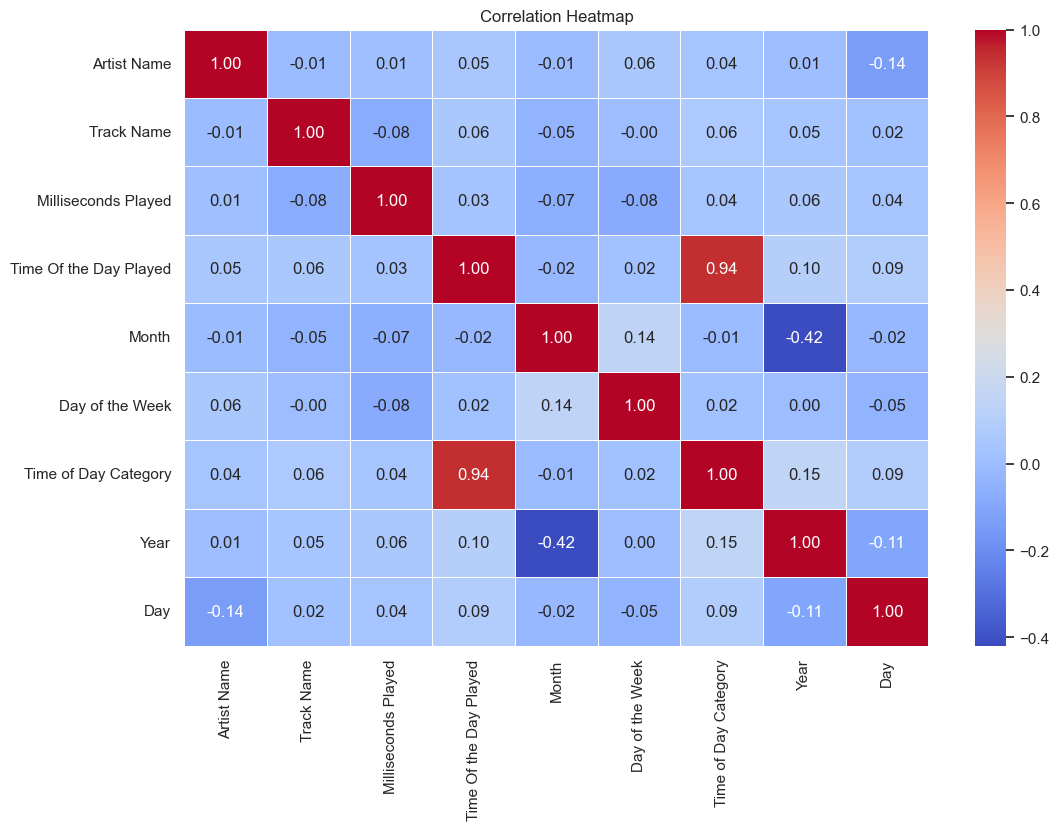

Strong Correlations with Target ('Time of Day Category'):
Time of Day Category      1.000000
Time Of the Day Played    0.944127
Year                      0.150038
Day                       0.090172
Track Name                0.064052
Milliseconds Played       0.039342
Artist Name               0.038628
Day of the Week           0.023806
Month                    -0.010735
Name: Time of Day Category, dtype: float64

Selected Strong Predictors for Time of Day Category:
['Time of Day Category', 'Time Of the Day Played', 'Year']


In [18]:
# Calculate correlations
correlations = df_copy.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


# Display strong correlations with the target variable
target_correlations = correlations['Time of Day Category'].sort_values(ascending=False)
print("Strong Correlations with Target ('Time of Day Category'):")
print(target_correlations)
# Set the correlation threshold
correlation_threshold = 0.1

# Identify features with high absolute correlation with the target variable
strong_predictors = target_correlations[abs(target_correlations) > correlation_threshold].index.tolist()

# Print the selected features
print()
print("Selected Strong Predictors for Time of Day Category:")
print(strong_predictors)

In [19]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

# Instantiate the model
model = GradientBoostingRegressor()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

best_model = GradientBoostingRegressor(n_estimators=best_params['n_estimators'],
                                       learning_rate=best_params['learning_rate'],
                                       max_depth=best_params['max_depth'])

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)


In [20]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 1.6108281397626543e-05
Mean Squared Error: 4.91988212928191e-10
R-squared: 0.999999999293156


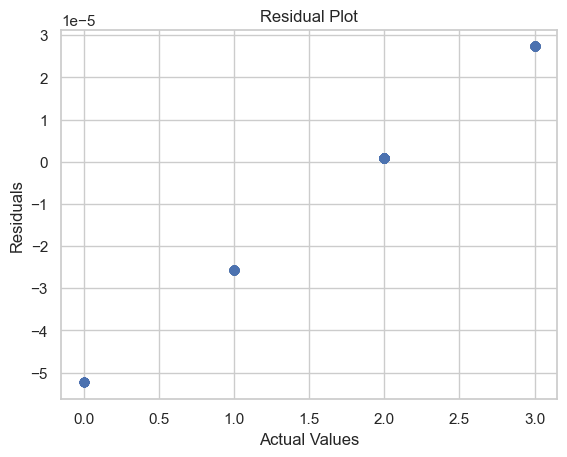

In [21]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()


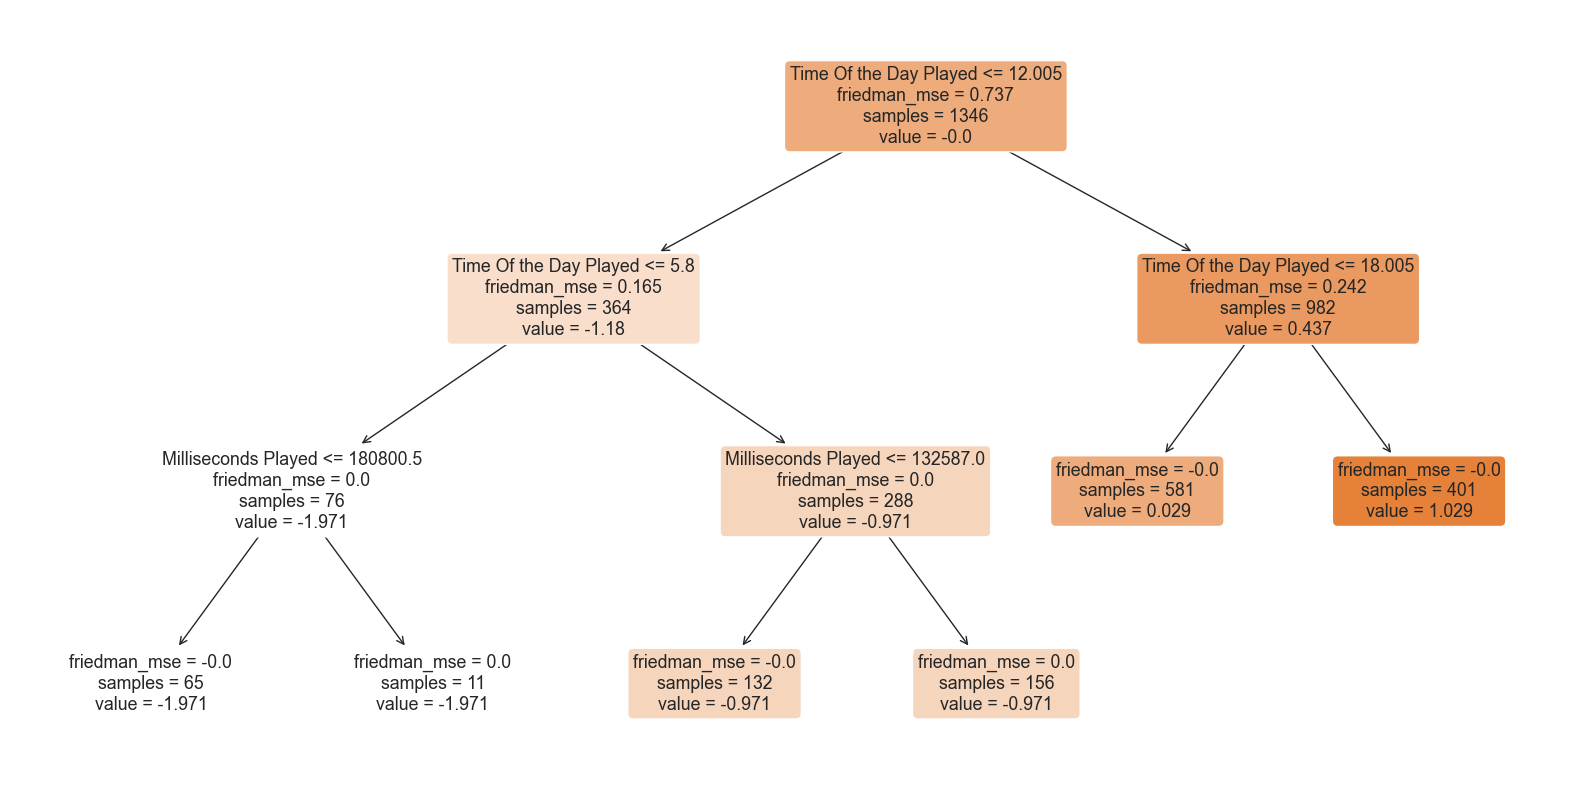

In [22]:
# Re-train the model with the best hyperparameters
final_model = GradientBoostingRegressor(n_estimators=best_params['n_estimators'],
                                         learning_rate=best_params['learning_rate'],
                                         max_depth=best_params['max_depth'])

final_model.fit(X_train, y_train)

# Visualize one tree from the ensemble
tree_to_visualize = 0  # Change this index to visualize a different tree
tree = final_model.estimators_[tree_to_visualize, 0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, rounded=True, feature_names=X_train.columns)
plt.show()


Classification Accuracy: 1.0


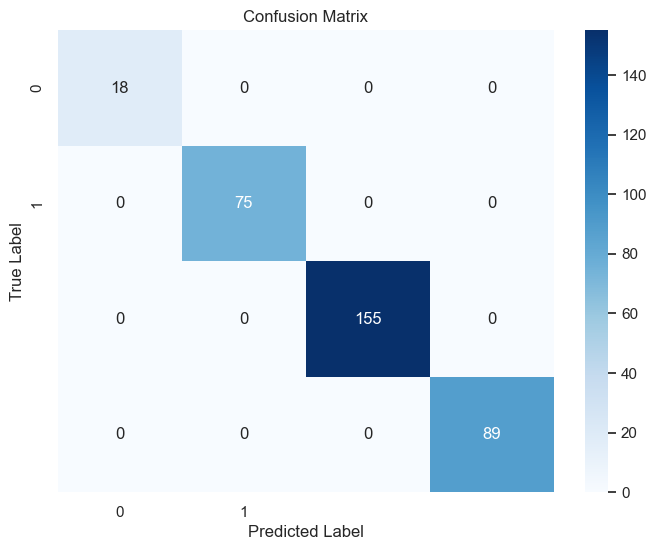

Total run time: 22.580676317214966 seconds


In [23]:
# Instantiate the classification model with the best hyperparameters
classification_model = GradientBoostingClassifier(n_estimators=best_params['n_estimators'],
                                                  learning_rate=best_params['learning_rate'],
                                                  max_depth=best_params['max_depth'])

# Train the model
classification_model.fit(X_train, y_train)

# Predict labels on the testing data
y_pred_class = classification_model.predict(X_test)

# Report classification accuracy
accuracy_class = accuracy_score(y_test, y_pred_class)
print(f'Classification Accuracy: {accuracy_class}')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

"""
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total run time: {elapsed_time} seconds")
#Total run time: 22.580676317214966 seconds
"""

## Conclussion
In conclusion, this project has provided valuable insights into my personal music listening journey. Through exploratory data analysis (EDA), feature engineering, and machine learning modeling, we uncovered patterns, trends, and intriguing details about the times, artists, and tracks that shape my musical preferences..

The visualizations and machine learning models presented in this project not only deepen our understanding of music listening habits but also showcase the versatility of data science techniques in analyzing personal datasets.

As with any project, there are always opportunities for further exploration and refinement. Future iterations could involve expanding the d (since the total rows of the .json file could argued to be small)ataset, incorporating more advanced machine learning algo which would be ideal in this case, since I am not sure my machine learning algorithm is working as intented from looking and the confusion matrix above.ience.

In summary, this project serves as a testament to the power of data-driven exploration and the synergy achieved by combining data science methodologies with emerging technologies like chatbots. Whether you're a fellow music enthusiast or a data science enthusiast, I hope this project sparks curiosity and inspires further exploration into the realms of personal data analytics.

Thank you for joining me on this musical data journey!